In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Imports
from keras.layers import Dense, Conv2D, AveragePooling2D, Input, Flatten, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model
import numpy as np
import os
from keras.regularizers import l2

In [1]:
from keras.utils import to_categorical
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Using TensorFlow backend.


170500096/170498071 [==============================] - 9s 0us/step


In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
import keras

model = resnet_v1(input_shape=(32, 32, 3), depth=20, num_classes=10)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

W0712 17:28:49.674327 139683064809344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0712 17:28:49.701190 139683064809344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 32, 32, 16)   64          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 32, 32, 16)   0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_5 (

In [12]:
train_data = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.01,
        zoom_range=0.01,
        fill_mode='nearest',
        horizontal_flip=True
)

model.fit_generator(train_data.flow(x_train, y_train, batch_size=2048),
                    validation_data=(x_test, y_test),
                    steps_per_epoch=25,
                    epochs=50)

W0712 17:33:43.002874 139683064809344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
25/25 [==============================] - 29s 1s/step - loss: 2.3421 - acc: 0.2693 - val_loss: 2.8588 - val_acc: 0.1849
Epoch 2/50
25/25 [==============================] - 22s 881ms/step - loss: 1.7202 - acc: 0.4201 - val_loss: 3.5833 - val_acc: 0.1939
Epoch 3/50
25/25 [==============================] - 23s 912ms/step - loss: 1.5713 - acc: 0.4819 - val_loss: 2.3621 - val_acc: 0.3581
Epoch 4/50
25/25 [==============================] - 23s 910ms/step - loss: 1.4650 - acc: 0.5230 - val_loss: 1.6572 - val_acc: 0.4792
Epoch 5/50
25/25 [==============================] - 23s 908ms/step - loss: 1.3785 - acc: 0.5599 - val_loss: 1.7122 - val_acc: 0.4709
Epoch 6/50
25/25 [==============================] - 23s 918ms/step - loss: 1.3071 - acc: 0.5847 - val_loss: 2.3834 - val_acc: 0.4052
Epoch 7/50
25/25 [==============================] - 23s 913ms/step - loss: 1.2463 - acc: 0.6077 - val_loss: 2.0853 - val_acc: 0.4015
Epoch 8/50
25/25 [==============================] - 23s 906ms/step - los

In [0]:
import h5py
model.save('/content/drive/My Drive/cifar.h5')

In [0]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/cifar.h5')

In [37]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

count = 0
img_count = 1
misclassified = np.empty((100, 32, 32, 3), dtype=np.float32)


for i in range(np.shape(x_test)[0]):
    out = np.argmax(np.squeeze(model.predict(np.expand_dims(x_test[i], axis=0))))
    y = np.argmax(y_test[i])
    if out != y:
        print(img_count, " Actual: ", y, "\tPredicted: ", out, "\tImage: ", i)
        last_conv_layer = model.get_layer("conv2d_20")
        class_output = model.output[:, out]
        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(x_test[i], axis=0)])
        for j in range(64):
            conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        heatmap = cv2.resize(heatmap, (32, 32))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(cv2.resize(x_test[i], (32, 32)), 0.6, heatmap, 0.4, 0)
        misclassified[count, :, :, :] = x_test[i]
        misclassified[count+1, :, :, :] = superimposed_img
        #img = misclassified[img_count] / 255
        #fig.add_subplot(rows, columns, img_count)
        img_count += 1
        #plt.imshow(img)
        count += 2
        if count==100:
            break
            
#plt.subplots_adjust(left=0.0, bottom=None, right=0.05, top=None, wspace=0.2, hspace=0)
#plt.show()

1  Actual:  0 	Predicted:  8 	Image:  3
2  Actual:  6 	Predicted:  4 	Image:  7
3  Actual:  0 	Predicted:  7 	Image:  10
4  Actual:  5 	Predicted:  4 	Image:  24
5  Actual:  2 	Predicted:  5 	Image:  25
6  Actual:  4 	Predicted:  2 	Image:  32
7  Actual:  2 	Predicted:  8 	Image:  35
8  Actual:  4 	Predicted:  7 	Image:  36
9  Actual:  5 	Predicted:  7 	Image:  42
10  Actual:  3 	Predicted:  6 	Image:  46
11  Actual:  0 	Predicted:  7 	Image:  52
12  Actual:  7 	Predicted:  3 	Image:  57
13  Actual:  4 	Predicted:  3 	Image:  58
14  Actual:  6 	Predicted:  3 	Image:  59
15  Actual:  3 	Predicted:  5 	Image:  61
16  Actual:  6 	Predicted:  3 	Image:  62
17  Actual:  2 	Predicted:  6 	Image:  65
18  Actual:  2 	Predicted:  8 	Image:  70
19  Actual:  0 	Predicted:  7 	Image:  74
20  Actual:  5 	Predicted:  7 	Image:  85
21  Actual:  2 	Predicted:  7 	Image:  86
22  Actual:  7 	Predicted:  8 	Image:  87
23  Actual:  3 	Predicted:  6 	Image:  91
24  Actual:  3 	Predicted:  5 	Image:  106
25

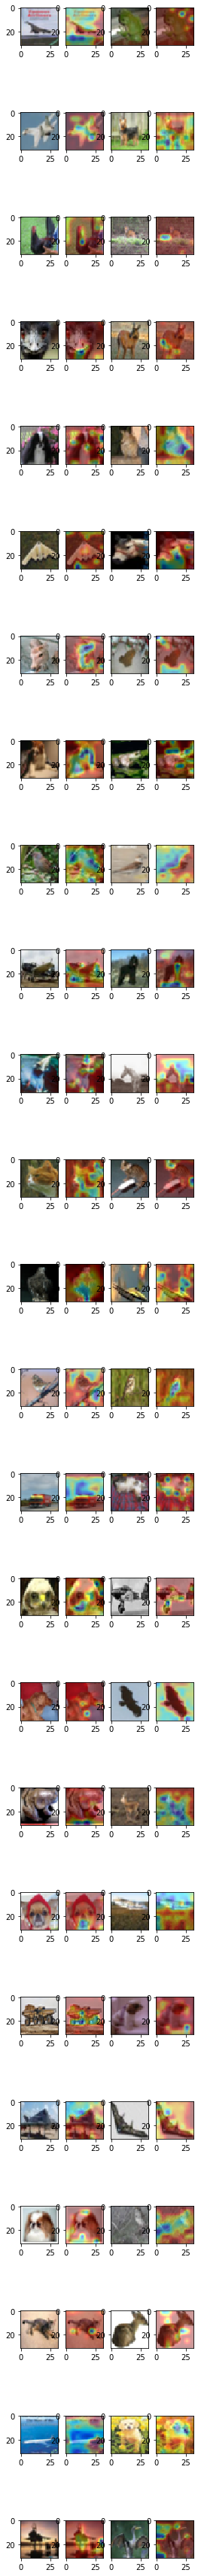

In [38]:
fig=plt.figure(figsize=(64, 64))
columns = 4
rows = 25
for i in range(1, 101):
    img = misclassified[i-1] / 255
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    
plt.subplots_adjust(left=0.0, bottom=None, right=0.05, top=None, wspace=0.2, hspace=0)
plt.show()

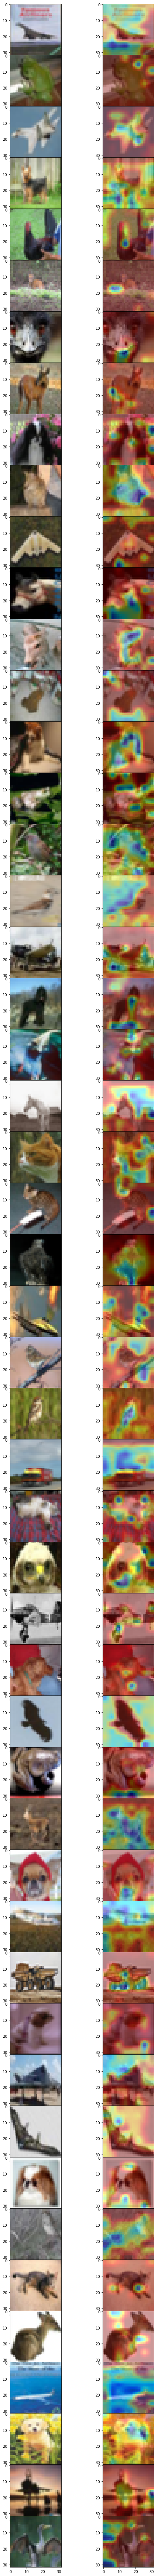

In [39]:
fig=plt.figure(figsize=(128, 128))
columns = 2
rows = 50
for i in range(1, 101):
    img = misclassified[i-1] / 255
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    
plt.subplots_adjust(left=0.0, bottom=None, right=0.05, top=None, wspace=0.2, hspace=0)
plt.show()